# RNN y sus aplicaciones en las series temporales

Se entrenan modelos diseñados para predecir el comportamiento de series temporales. En este caso, se utilizará un conjunto de datos de temperaturas y, a través de la aplicación de redes neuronales recurrentes (RNN), se intentará prever los valores futuros de la serie temporal disponible. Aunque tradicionalmente esta tarea se realiza con modelos ARIMA, en esta práctica se demostrará cómo el uso de RNN puede ser una excelente alternativa para el modelado de series temporales.

En primer lugar hay que importar tensorflow.

In [1]:
import tensorflow as tf
print(tf.__version__)

2.15.0


El siguiente paso es importar las bibliotecas numpy y matplotlib. Además, se define el método **plot_series** que se utilizará para hacer las gráficas de las series temporales.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

A continuación se descarga el dataset de las temperaturas mínimas diarias.

In [3]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2024-06-16 17:52:47--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.02s   

2024-06-16 17:52:47 (3.03 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



En este paso, se utilizará la biblioteca csv de Python para guardar y poder leer el dataset de temperaturas mínimas diarias que ha sido descargado en el paso anterior. Además, se construye la variable **series** que será donde se guarde la serie temporal. Por último, siempre que se trate con una serie temporal, es una buena práctica hacer un gráfico para poder verla y tener una idea de cómo es.

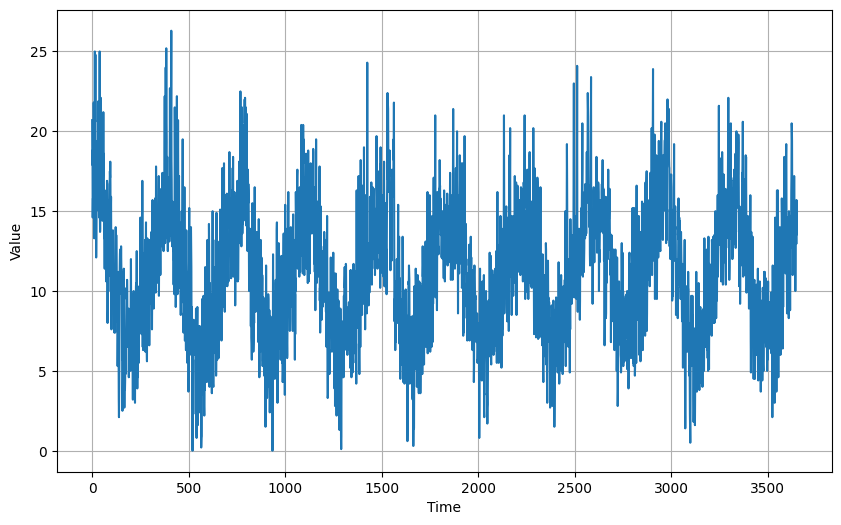

In [4]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

# 2. Creación de las variables necesarias para el diseño de la red neuronal

Una técnica muy común cuando se trata con series temporales es utilizar una ventana temporal que se vaya desplazando sobre la serie temporal para reducir su análisis a lo que ocurre en ese ventana de forma local, para a continuación realizar el modelado global.

In [5]:
## variables para la técnica de la ventana temporal
split_time = 2500
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

## Split del dataset en entrenamiento y validación

time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

# 3. Diseño de la función para predecir los siguientes valores de la serie temporal usando la técnica de la ventana temporal

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

A continuación, y usando como modelo el método **windowed_dataset** se procederá a adaptar el método **model_forecast** que se usará para predecir los siguientes valores de la serie temporal utilizando la técnica de la ventana temporal.

In [34]:
def model_forecast(model, series, window_size):

    # Crea la variable ds
    ds = tf.data.Dataset.from_tensor_slices(series)

    # Actualiza la ventana de la variable ds
    ds = ds.window(window_size, shift=1, drop_remainder=True)

    # Crear el flat_map, teniendo en cuenta el tamaño de window_size
    ds = ds.flat_map(lambda w: w.batch(window_size))

    ds = ds.batch(32).prefetch(1)

    # Crea la variable forecast
    forecast = model.predict(ds)

    return forecast

A continuación, se limpia la sesión de keras, y se inicializan las variables necesarias para poder diseñar el modelo de series temporales a entrenar usando RNN.

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256

# 4. Diseño de la red neuronal

In [9]:
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Lambda

model = tf.keras.models.Sequential([
    # Capa de convolución en una dimensión
    Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", activation="relu", input_shape=[None, 1]),

    # Primera capa LSTM
    LSTM(64, return_sequences=True),

    # Segunda capa LSTM
    LSTM(64, return_sequences=True),

    # Capa densa con 30 neuronas
    Dense(30, activation="relu"),

    # Capa densa con 10 neuronas
    Dense(10, activation="relu"),

    # Capa densa con 1 neurona
    Dense(1),

    # Capa Lambda
    Lambda(lambda x: x * 400)
])

# 5. Entrenamiento de la red neuronal

In [11]:
from tensorflow.keras.callbacks import LearningRateScheduler

lr_schedule = LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

In [12]:
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import MeanAbsoluteError

model.compile(
    loss=Huber(),
    optimizer=SGD(learning_rate=1e-8, momentum=0.9),
    metrics=[MeanAbsoluteError()]
)

Para terminar se entrena el modelo previamente diseñado y compilado en los pasos anteriores.

In [13]:
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
10/10 [==============================] - 11s 345ms/step - loss: 46.5963 - mean_absolute_error: 47.0951 - lr: 1.0000e-08
Epoch 2/100
10/10 [==============================] - 4s 290ms/step - loss: 45.6380 - mean_absolute_error: 46.1369 - lr: 1.1220e-08
Epoch 3/100
10/10 [==============================] - 3s 283ms/step - loss: 44.1765 - mean_absolute_error: 44.6755 - lr: 1.2589e-08
Epoch 4/100
10/10 [==============================] - 5s 463ms/step - loss: 42.4084 - mean_absolute_error: 42.9074 - lr: 1.4125e-08
Epoch 5/100
10/10 [==============================] - 3s 284ms/step - loss: 40.3885 - mean_absolute_error: 40.8874 - lr: 1.5849e-08
Epoch 6/100
10/10 [==============================] - 3s 277ms/step - loss: 38.1190 - mean_absolute_error: 38.6179 - lr: 1.7783e-08
Epoch 7/100
10/10 [==============================] - 5s 457ms/step - loss: 35.5850 - mean_absolute_error: 36.0839 - lr: 1.9953e-08
Epoch 8/100
10/10 [==============================] - 3s 280ms/step - loss: 32.7593

# 6. Actualización del learning rate según los resultados obtenidos del primer entrenamiento de la red neuronal

Después del entrenamiento de la red neuronal se ve que learning rate resultante es de 1e-5. Se visualizará gráficamente para entender el motivo por el que se ha usado ese valor. En la gráfica se puede ver cómo el learning rate con el que menos loss hay es 1e-5, y por ese motivo, se debe volver a entrenar la red neuronal con dicho learning rate.

(1e-08, 0.0001, 0.0, 60.0)

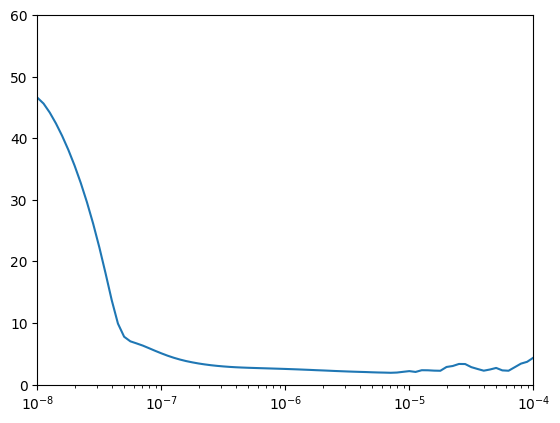

In [14]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

Se vuelve a inicializar la sesión de entrenamiento y la variable train_set:

In [15]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)

In [16]:
model2 = Sequential([
    Conv1D(filters=60, kernel_size=5, strides=1, padding="causal", activation="relu", input_shape=[None, 1]),
    LSTM(64, return_sequences=True),
    LSTM(64, return_sequences=True),
    Dense(30, activation="relu"),
    Dense(10, activation="relu"),
    Dense(1),
    Lambda(lambda x: x * 400)
])

In [51]:
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import MeanAbsoluteError

model2.compile(
    loss=Huber(),
    optimizer=SGD(learning_rate=1e-8, momentum=0.9),
    metrics=[MeanAbsoluteError()]
)

In [18]:
history2 = model2.fit(train_set,callbacks=[lr_schedule],epochs=150)

Epoch 1/150
25/25 [==============================] - 7s 207ms/step - loss: 425.4392 - mean_absolute_error: 425.9392 - lr: 1.0000e-08
Epoch 2/150
25/25 [==============================] - 5s 192ms/step - loss: 657.7737 - mean_absolute_error: 658.2737 - lr: 1.1220e-08
Epoch 3/150
25/25 [==============================] - 5s 182ms/step - loss: 674.0267 - mean_absolute_error: 674.5266 - lr: 1.2589e-08
Epoch 4/150
25/25 [==============================] - 4s 160ms/step - loss: 674.7149 - mean_absolute_error: 675.2148 - lr: 1.4125e-08
Epoch 5/150
25/25 [==============================] - 6s 235ms/step - loss: 674.2275 - mean_absolute_error: 674.7274 - lr: 1.5849e-08
Epoch 6/150
25/25 [==============================] - 4s 152ms/step - loss: 673.5901 - mean_absolute_error: 674.0901 - lr: 1.7783e-08
Epoch 7/150
25/25 [==============================] - 6s 233ms/step - loss: 672.8683 - mean_absolute_error: 673.3682 - lr: 1.9953e-08
Epoch 8/150
25/25 [==============================] - 4s 161ms/step - 

# 7. Predicción de los siguientes valores de la serie temporal

Para concluir la actividad, se usa el método model_forecast que se ha diseñado utilizando el método de la ventana temporal para hacer el nuevo metodo rnn_forecast con el cual se calcularán los nuevos valores de la serie temporal. Posteriormente, se pinta una gráfica para ver esos resultados y comprobar de forma visual que son correctos. Además, se dan los resultados de esas predicciones en forma númerica, de esta forma, este modelo diseñado en esta actividad podría ser el input de un nuevo algoritmo si fuera necesario.

In [35]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]


113/113 [==============================] - 4s 34ms/step


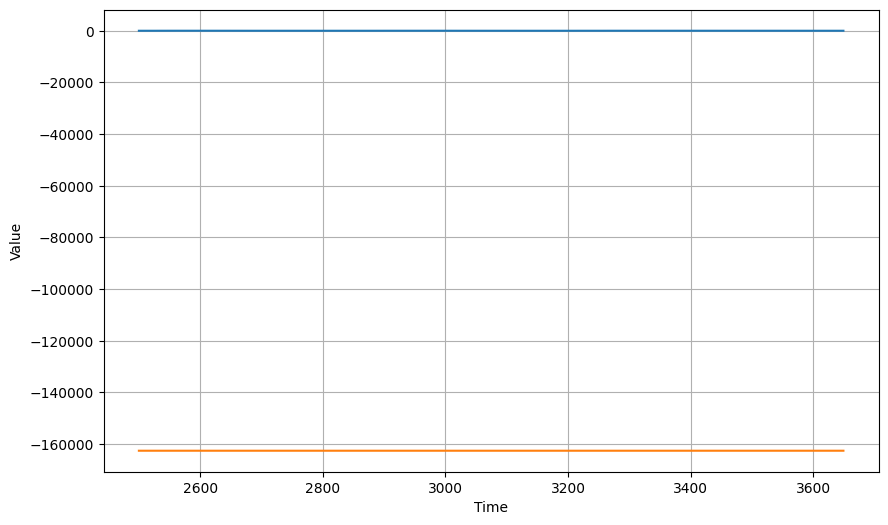

In [50]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [37]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

162554.47

In [38]:
print(rnn_forecast)

[-162542.78 -162542.78 -162542.78 ... -162542.78 -162542.78 -162542.78]


# 8. Mostrar gráficamente los resultados.

Una vez obtenido el resultado de la actividad, se procede a revisr de forma gráfica el training y validation loss a lo largo de los epochs en este nuevo entrenamiento con el learning rate optimizado.

In [44]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

A continuación se realiza el plot de la pérdida frente a los epochs

<Figure size 640x480 with 0 Axes>

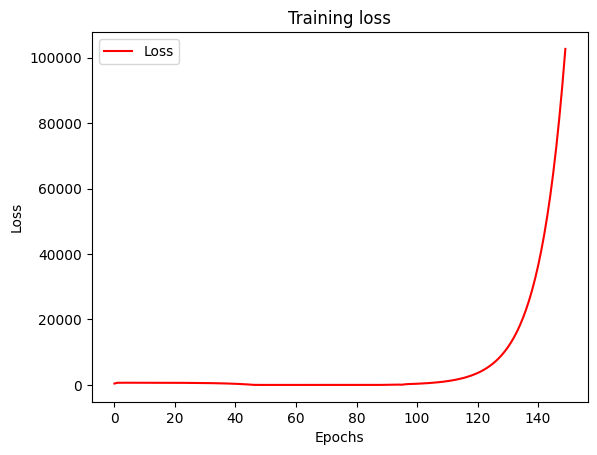

<Figure size 640x480 with 0 Axes>

In [45]:
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

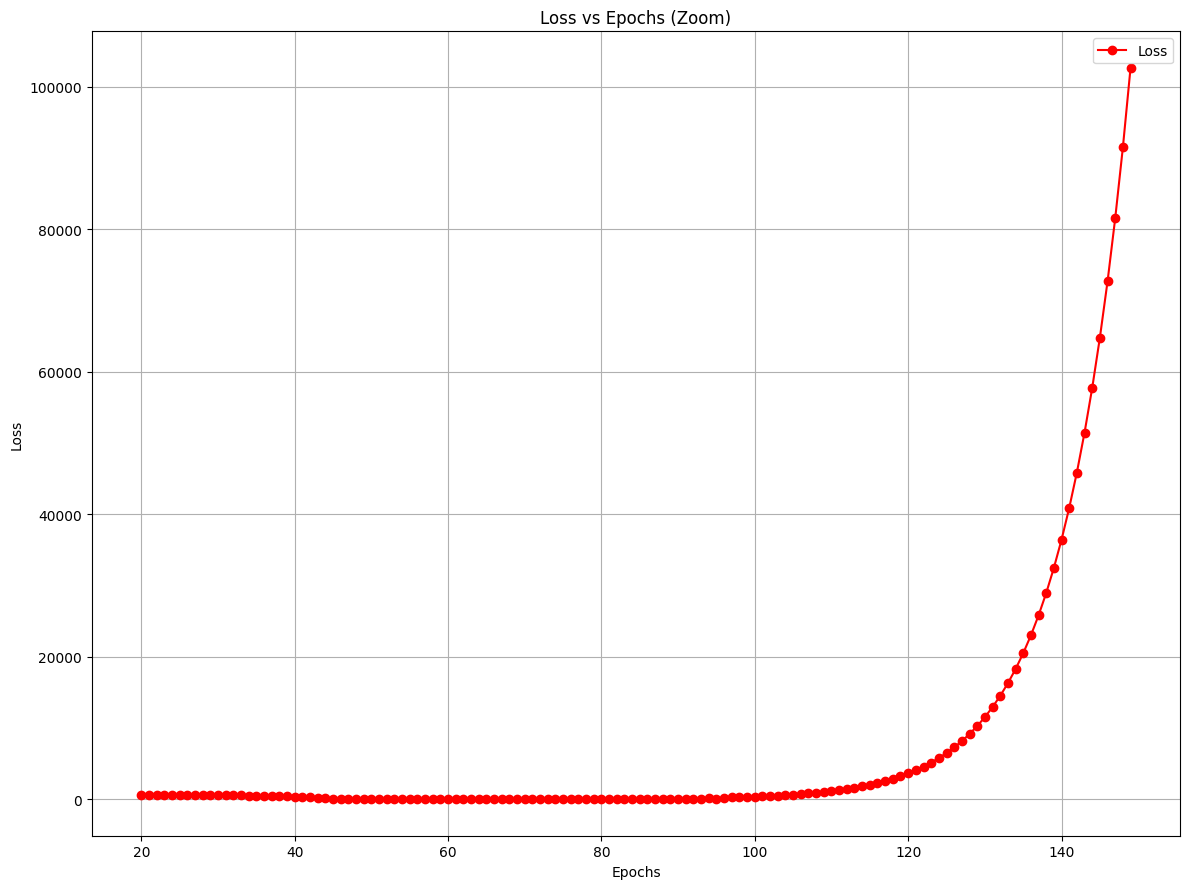

In [49]:

zoomed_loss = loss[20:]
zoomed_epochs = range(20,150)

plt.figure(figsize=(12, 9))
plt.plot(zoomed_epochs, zoomed_loss, label='Loss', marker='o', color='r')
plt.title('Loss vs Epochs (Zoom)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()